<a href="https://colab.research.google.com/github/gamzef/INF003/blob/master/Endabgabe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#As stated in the description, the data for this competition comes from a experimental set-up used to study earthquake physics. 
#Our goal is to predict the time remaining before the next laboratory earthquake. 
#The only feature we have is the seismic signal (acoustic data), which is recorded using a piezoceramic sensor and corresponds to the voltage upon deformation (in integers).
#Training data: single, continuous segment of experimental data.

#Test data: consists of a folder containing many small segments. The data within each test file is continuous, but the test files do not represent a continuous segment of the experiment.

#Both the training and the testing set come from the same experiment.

#There is no overlap between the training and testing sets.

**Install and Import Dependencies**

In [ ]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from tensorflow import keras
from sklearn.metrics import mean_absolute_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
os.listdir('../content/drive/My Drive/input/')

['sample_submission.csv', 'test']

**Import Dataset from Kaggle**

In [ ]:
from google.colab import files  #Colab's file access feature
uploaded = files.upload()   #retrieve uploaded file
#upload Kaggle JSON File 
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/kaggle/kaggle.json 

Saving kaggle.json to kaggle.json
chmod: cannot access '/root/kaggle/kaggle.json': No such file or directory


In [ ]:
#download earthquake data
!kaggle competitions download -c LANL-Earthquake-Prediction

seg_00648a.csv: Skipping, found more recently modified local copy (use --force to force download)
seg_00cc91.csv: Skipping, found more recently modified local copy (use --force to force download)
seg_0042cc.csv: Skipping, found more recently modified local copy (use --force to force download)
seg_0012b5.csv: Skipping, found more recently modified local copy (use --force to force download)
seg_004314.csv: Skipping, found more recently modified local copy (use --force to force download)
seg_00a37e.csv: Skipping, found more recently modified local copy (use --force to force download)
seg_006e4a.csv: Skipping, found more recently modified local copy (use --force to force download)
seg_00c35b.csv: Skipping, found more recently modified local copy (use --force to force download)
seg_00be11.csv: Skipping, found more recently modified local copy (use --force to force download)
seg_004ee5.csv: Skipping, found more recently modified local copy (use --force to force download)
seg_00184e.csv: Skip

In [ ]:
#unzip training data for usage
!unzip train.csv.zip

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


**Data Analysis**

In [ ]:
#train.csv'deki datayı okur, ilk data tipi acoustic_data, integer, ikincisi time to failure float. 
train_data = pd.read_csv('train.csv', nrows=6000000, dtype = {'acoustic_data': np.int16, 'time_to_failure': np.float32})

In [ ]:
pd.options.display.precision = 15
train_data.head()

,acoustic_data,time_to_failure
0,12,1.469099998474121
1,6,1.469099998474121
2,8,1.469099998474121
3,5,1.469099998474121
4,8,1.469099998474121


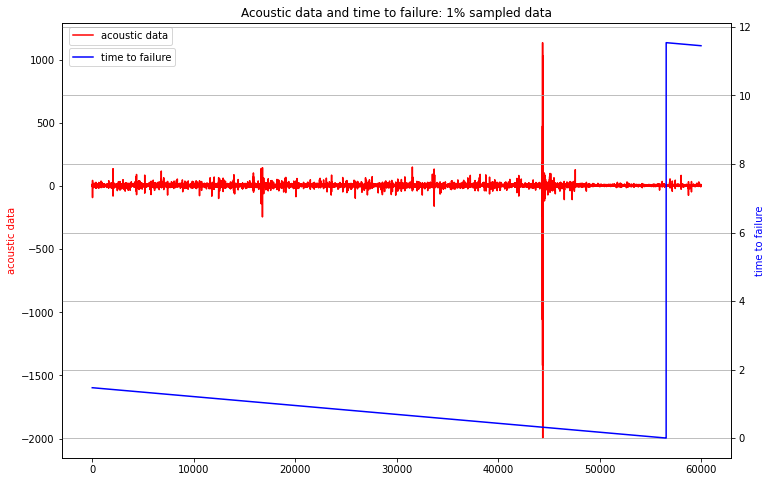

In [ ]:
#visualize of 1% of dataset (her 100 elemanda bir veri alıyor.)
train_ad_sample_df = train_data['acoustic_data'].values[::100]
train_ttf_sample_df = train_data['time_to_failure'].values[::100]

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title = "Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

#There is a point before the actual earthquake 
#where there's a spike in acoustic activity seismographic activity.

#https://www.kaggle.com/gpreda/lanl-earthquake-eda-and-prediction

Visualize all of the data

![image](https://drive.google.com/uc?export=view&id=1eEbV1lEoEm0rR3qoUvNYYK5_bzj-vK66)


In [ ]:
#import
train_data = pd.read_csv('train.csv',dtype = {'acoustic_data':np.int16,'time_to_failure':np.float32})

In [ ]:
rows = 150_000
segments = int(np.floor(train_data.shape[0] / rows))  #630 milyon / 150000 = 4194

X_train = pd.DataFrame(index = range(segments),dtype = np.float32,columns = ['mean','std','99quat','50quat','25quat','1quat'])
y_train = pd.DataFrame(index = range(segments),dtype = np.float32,columns = ['time_to_failure'])

#https://www.kaggle.com/gpreda/lanl-earthquake-eda-and-prediction

In [ ]:
for segment in tqdm(range(segments)):
    x = train_data[segment*rows:segment*rows+rows]
    y = x['time_to_failure'].values[-1]
    x = x['acoustic_data'].values
    X_train.loc[segment,'mean'] = np.mean(x)
    X_train.loc[segment,'std']  = np.std(x)
    X_train.loc[segment,'99quat'] = np.quantile(x,0.99)
    X_train.loc[segment,'50quat'] = np.quantile(x,0.5)
    X_train.loc[segment,'25quat'] = np.quantile(x,0.25)
    X_train.loc[segment,'1quat'] =  np.quantile(x,0.01)
    y_train.loc[segment,'time_to_failure'] = y

#https://www.kaggle.com/gpreda/lanl-earthquake-eda-and-prediction

100%|██████████| 4194/4194 [00:42<00:00, 99.29it/s]


In [ ]:
X_train.head()

,mean,std,99quat,50quat,25quat,1quat
0,4.884113311767578,5.101089000701904,18.0,5.0,3.0,-8.0
1,4.725766658782959,6.588801860809326,21.0,5.0,2.0,-11.0
2,4.906393527984619,6.967373847961426,26.0,5.0,2.0,-15.0
3,4.902239799499512,6.922282218933105,22.0,5.0,2.0,-12.0
4,4.908720016479492,7.301085948944092,26.0,5.0,2.0,-15.0


In [ ]:
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X_train)

In [ ]:
from keras.layers.core import Dropout

model = Sequential()
model.add(Dense(256, activation="relu", input_shape=(6,)))
model.add(Dropout(0.3))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(96, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="linear"))

optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='mae')

In [ ]:
history = model.fit(X_scaler,y_train.values.flatten(),epochs = 500, batch_size=64)

Epoch 1/500
4194/4194 [==============================] - 0s 80us/step - loss: 5.4762
Epoch 2/500
4194/4194 [==============================] - 0s 51us/step - loss: 4.4720
Epoch 3/500
4194/4194 [==============================] - 0s 49us/step - loss: 3.0789
Epoch 4/500
4194/4194 [==============================] - 0s 55us/step - loss: 2.5823
Epoch 5/500
4194/4194 [==============================] - 0s 49us/step - loss: 2.4832
Epoch 6/500
4194/4194 [==============================] - 0s 50us/step - loss: 2.4365
Epoch 7/500
4194/4194 [==============================] - 0s 49us/step - loss: 2.4039
Epoch 8/500
4194/4194 [==============================] - 0s 47us/step - loss: 2.3515
Epoch 9/500
4194/4194 [==============================] - 0s 50us/step - loss: 2.3535
Epoch 10/500
4194/4194 [==============================] - 0s 60us/step - loss: 2.3262
Epoch 11/500
4194/4194 [==============================] - 0s 63us/step - loss: 2.3326
Epoch 12/500
4194/4194 [==============================] - 0s 62

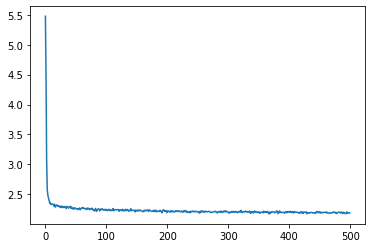

In [ ]:
plt.plot(history.history['loss'])

In [ ]:
model.summary()     #256(neurons in the first layer) * 6(input) + 256 (bias)  for layer1
                    #256 * 128 + 128(bias) for layer2
                    #96 * 128 + 96 for layer 3
                    #1 * 96 + 1 for layer 4

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               1792      
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 96)                12384     
_________________________________________________________________
dropout_9 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                

In [ ]:
sub_data = pd.read_csv('../content/drive/My Drive/input/sample_submission.csv',index_col = 'seg_id')

In [ ]:
X_test = pd.DataFrame(columns = X_train.columns,dtype = np.float32,index = sub_data.index)

In [ ]:
for seq in tqdm(X_test.index):
    test_data = pd.read_csv('../content/drive/My Drive/input/test/'+seq+'.csv')     #2624 .csv file and each of them has 150000 segments(row)
    x = test_data['acoustic_data'].values
    X_test.loc[seq,'mean'] = np.mean(x)
    X_test.loc[seq,'std']  = np.std(x)
    X_test.loc[seq,'99quat'] = np.quantile(x,0.99)
    X_test.loc[seq,'50quat'] = np.quantile(x,0.5)
    X_test.loc[seq,'25quat'] = np.quantile(x,0.25)
    X_test.loc[seq,'1quat'] =  np.quantile(x,0.01)


100%|██████████| 2624/2624 [04:26<00:00,  9.84it/s]


In [ ]:
X_test_scaler = scaler.transform(X_test)

In [ ]:
pred = model.predict(X_test_scaler)

In [ ]:
sub_data['time_to_failure'] = pred
sub_data['seg_id'] = sub_data.index

In [ ]:
sub_data.head()

,time_to_failure,seg_id
seg_id,,
seg_00030f,5.133993148803711,seg_00030f
seg_0012b5,4.466531753540039,seg_0012b5
seg_00184e,3.813571691513062,seg_00184e
seg_003339,8.414169311523438,seg_003339
seg_0042cc,5.473489761352539,seg_0042cc


In [ ]:
sub_data.to_csv('sub_earthquake.csv',index = False)
sub_data.time_to_failure.describe()

count    2624.000000000000000
mean        5.556282997131348
std         2.245691537857056
min         0.354025751352310
25%         3.991442203521729
50%         5.059394836425781
75%         7.294184923171997
max        11.503429412841797
Name: time_to_failure, dtype: float64

In [ ]:
ss = pd.read_csv('sub_earthquake.csv', nrows=1000, dtype = {'acoustic_data': np.int16, 'time_to_failure': np.float32})

In [ ]:
ss.head()

,time_to_failure,seg_id
0,5.133993148803711,seg_00030f
1,4.466531753540039,seg_0012b5
2,3.813571691513062,seg_00184e
3,8.414169311523438,seg_003339
4,5.473489761352539,seg_0042cc
